In this notebook I will train translation system with seq2seq model

In [4]:
DATA_PATH="./data/translation/deu.txt"

with open(DATA_PATH, "r") as f:
    lines = f.readlines()

data_set = [line.split("\t")[:2] for line in lines]
data_set[-1]



['Doubtless there exists in this world precisely the right woman for any given man to marry and vice versa; but when you consider that a human being has the opportunity of being acquainted with only a few hundred people, and out of the few hundred that there are but a dozen or less whom he knows intimately, and out of the dozen, one or two friends at most, it will easily be seen, when we remember the number of millions who inhabit this world, that probably, since the earth was created, the right man has never yet met the right woman.',
 'Ohne Zweifel findet sich auf dieser Welt zu jedem Mann genau die richtige Ehefrau und umgekehrt; wenn man jedoch in Betracht zieht, dass ein Mensch nur Gelegenheit hat, mit ein paar hundert anderen bekannt zu sein, von denen ihm nur ein Dutzend oder weniger nahesteht, darunter höchstens ein oder zwei Freunde, dann erahnt man eingedenk der Millionen Einwohner dieser Welt\xa0leicht, dass seit Erschaffung ebenderselben wohl noch nie der richtige Mann der 

In [8]:
import re
from typing import List, Tuple
# regex: words OR any single non-space, non-word character (= punctuation)
_TOKEN_RE = re.compile(r"\w+|[^\w\s]", flags=re.UNICODE)

def tokenize(dataset):
    """
    Parameters
    ----------
    dataset : list of (src, tgt) sentence pairs

    Returns
    -------
    tokenised_dataset : list of ([tokens_src], [tokens_tgt])
    vocab             : {token -> index} built over the whole dataset
    """
    src_data, tgt_data = [], []
                       # ensure <eos> is in the vocab

    for src, tgt in dataset:
        tokens_src = _TOKEN_RE.findall(src.lower()) + ["<eos>"]
        tokens_tgt = _TOKEN_RE.findall(tgt.lower()) + ["<eos>"]

        src_data.append(tokens_src)
        tgt_data.append(tokens_tgt)

    return src_data, tgt_data

src, tgt = tokenize(data_set)


In [9]:
src[:6], tgt[:6]

([['go', '.', '<eos>'],
  ['hi', '.', '<eos>'],
  ['hi', '.', '<eos>'],
  ['run', '!', '<eos>'],
  ['run', '.', '<eos>'],
  ['wow', '!', '<eos>']],
 [['geh', '.', '<eos>'],
  ['hallo', '!', '<eos>'],
  ['grüß', 'gott', '!', '<eos>'],
  ['lauf', '!', '<eos>'],
  ['lauf', '!', '<eos>'],
  ['potzdonner', '!', '<eos>']])

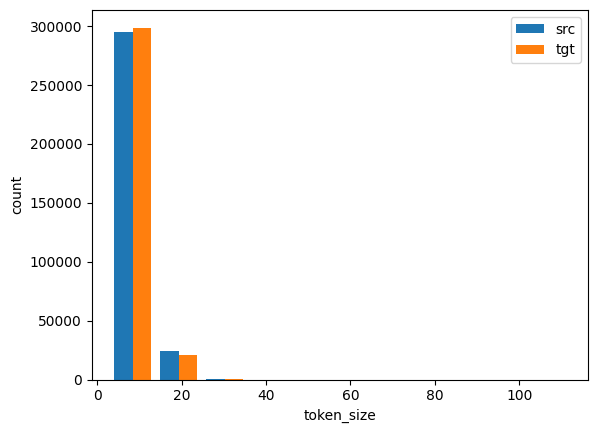

In [10]:
import matplotlib.pyplot as plt
def show_list_len_pair_hist(legend: List[str], xlabel: str, ylabel: str, xlist: List[List[str]], ylist: List[List[str]]):
    fig, ax = plt.subplots()
    ax.hist([[len(x) for x in xlist], [len(y) for y in ylist]], label=legend)
    ax.legend(legend)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

show_list_len_pair_hist(["src","tgt"], "token_size", "count", src, tgt)

In [29]:
from typing import List
from collections import Counter


class Vocabulary:

    def __init__(self,token_list: List[List[str]], min_freq: int=2, unknown_token:str='<unk>', reserved_tokens:List[str]=['<pad>', '<bos>', '<eos>']):
        token_counter = Counter([token for line in token_list for token in line])
        sorted_token_counter = list(sorted(token_counter.items(), key=lambda x: x[1]))
        first_index=0
        for token, count in sorted_token_counter:
            if count == 2:
                break
            first_index += 1 

        self.vocabulary= [unknown_token] + reserved_tokens + [token for token, _ in sorted_token_counter[first_index:]]
        self.token_to_idx = {token: idx for idx, token in enumerate(self.vocabulary)}
        self.idx_to_token = {idx: token for idx, token in enumerate(self.vocabulary)}

    
    def __len__(self):
        return len(self.vocabulary)

    def __getitem__(self,tokens: List[str]):
        return [self.token_to_idx[token] if token in self.token_to_idx 
        else self.token_to_idx['<unk>'] 
        for token in tokens]

    def from_tokens_to_string(self,tokens: List[int]):
        return ' '.join([self.idx_to_token[idx] for idx in tokens])          

In [31]:
src_vcb = Vocabulary(src,2)
src_vcb.from_tokens_to_string(src_vcb[src[0]])

'go . <eos>'